In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import ipywidgets as widgets
from IPython.display import display
import seaborn as sns
from scipy.stats import wilcoxon
from statsmodels.stats.multitest import multipletests


In [2]:
def get_cmaps():
    cmaps= { 
        'pretrain': {'none': sns.color_palette("tab10", 10)[0], 
                        'diffusion': sns.color_palette("tab10", 10)[1], 
                        'cellsorter': sns.color_palette("tab10", 10)[2],
                        'contrastive':sns.color_palette("tab10", 10)[3],
                        'flow': sns.color_palette("tab10", 10)[4],
                    },
        'encoder': {'set_transformer': sns.color_palette("Paired")[0],
                    'cell_transformer': sns.color_palette("Paired")[1],
                    'abmil': sns.color_palette("Paired")[2],
                    'pseudo_bulk': sns.color_palette("Paired")[3],
                    'celltypefracs': sns.color_palette("Paired")[4],
                    'celltypemeans': sns.color_palette("Paired")[5],
                    'catfracsmeans': sns.color_palette("Paired")[6],
                    'kmeans30': sns.color_palette("Paired")[7],
                    'kmeans60': sns.color_palette("Paired")[8],
        }
    }

    return cmaps

In [3]:
def load_all_params():
    # load json as dict
    files = os.listdir('/data/rna_rep_learning/scset/outputs/params')
    files = [f for f in files if f.endswith('.json')]
    params = []
    for f in files:
        with open('/data/rna_rep_learning/scset/outputs/params/' + f, 'r') as file:
            params.append(json.load(file))
    df = pd.DataFrame(params)
    return df

def load_results(results_dir):
    files = os.listdir(results_dir)
    files = [f for f in files if f.endswith('.csv')]
    results = []
    for f in files:
        res = pd.read_csv(results_dir + '/' + f)
        results.append(res)
    results = pd.concat(results)
    return results

def add_columns_to_results(annotations, results, columns=['pretrain']):
    # add pretrain column to results using run_name column
    annotations = annotations.set_index('run_name')
    for col in columns:
        results[col] = results['run_name'].apply(lambda x: annotations.loc[x][col])

def get_results_of_experiment_series(tag):
    df = load_all_params()
    df = df[df.run_name != 'debug_run']
    df.loc[df['pretrain'].isna(),'pretrain'] = 'none'
    df = df.loc[df['debug'] == False]
    df.loc[df['tag'].isna(),'tag'] = 'none'

    df_subset = df
    df_subset = df_subset[df_subset.tag == tag]

    results = load_results(results_dir='/data/rna_rep_learning/scset/outputs/results')
    results = results[results.run_name.isin(df_subset.run_name)]

    extra_annotation = ['pretrain', 'encoder','tag','h5ad_loc', 'max_num_cells'] #'model' was updated to 'encoder' on 10.14.24, will need to update this depending on when models were run
    add_columns_to_results(df_subset, results, columns=extra_annotation)
    return results

def overview_experiment_series(results, score="test_acc", x='pretrain', hue='encoder', titlepad=10):
    #results = get_results_of_experiment_series(tag)

    cmaps= get_cmaps()
    if hue in cmaps.keys():
        cmap = cmaps[hue]
        hue_order = list(cmap.keys())
    else:
        cmap = None
        hue_order = None
    
    results_lp = results[(results.experiment == 'linear probe') & (results.metric == score)]
    results_ft_frozen = results[(results.experiment == 'MLP') & (results.metric == score)]
    results_ft_endtoend = results[(results.experiment == 'FT End-to-End') & (results.metric == score)]

    fig, ax = plt.subplots(1,3, figsize=(20, 5))
    # increase fontsize
    sns.set_context("talk")
    sns.boxplot(data=results_lp, x=x, y='score', hue=hue, ax=ax[0], palette=cmap, hue_order=hue_order)
    ax[0].set_title('Linear probe', pad=titlepad)

    sns.boxplot(data=results_ft_endtoend, x=x, y='score', hue=hue, ax=ax[1], palette=cmap, hue_order=hue_order)
    ax[1].set_title('Finetuned - end-to-end', pad=titlepad)

    sns.boxplot(data=results_ft_frozen, x=x, y='score', hue=hue, ax=ax[2], palette=cmap, hue_order=hue_order)
    ax[2].set_title('Finetuned - frozen', pad=titlepad)

    for a in ax:
        a.set_ylim(0,1)

    #only include legend on ax[2] and set it to the right of the plot
    ax[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    #remove legend from axes 0,1
    #ax[0].get_legend().remove()
    #ax[1].get_legend().remove()

    return fig, ax

def overview_experiment_series_bothways(results, score="test_acc", x='pretrain', hue='encoder'):
    #results = get_results_of_experiment_series(tag)

    cmaps= get_cmaps()
    if hue in cmaps.keys():
        cmap = cmaps[hue]
        hue_order = list(cmap.keys())
    else:
        cmap = None
        hue_order = None
    results_lp = results[(results.experiment == 'linear_probe') & (results.metric == score)]
    results_ft_frozen = results[(results.experiment == 'supervised_frozen') & (results.metric == score)]
    results_ft_endtoend = results[(results.experiment == 'supervised') & (results.metric == score)]

    fig, ax = plt.subplots(2,3, figsize=(20, 12))
    #add vertical space between rows of subplots
    fig.subplots_adjust(hspace=0.5)
    sns.boxplot(data=results_lp, x=x, y='score', hue=hue, ax=ax[0,0], palette=cmap, hue_order=hue_order)
    ax[0,0].set_title('Linear probe')

    sns.boxplot(data=results_ft_endtoend, x=x, y='score', hue=hue, ax=ax[0,1], palette=cmap, hue_order=hue_order)
    ax[0,1].set_title('Finetuned - end-to-end')

    sns.boxplot(data=results_ft_frozen, x=x, y='score', hue=hue, ax=ax[0,2], palette=cmap, hue_order=hue_order)
    ax[0,2].set_title('Finetuned - frozen')

    sns.boxplot(data=results_lp, x=hue, y='score', hue=x, ax=ax[1,0], palette=cmap, hue_order=hue_order)
    ax[1,0].set_title('Linear probe')

    sns.boxplot(data=results_ft_endtoend, x=hue, y='score', hue=x, ax=ax[1,1], palette=cmap, hue_order=hue_order)
    ax[1,1].set_title('Finetuned - end-to-end')

    sns.boxplot(data=results_ft_frozen, x=hue, y='score', hue=x, ax=ax[1,2], palette=cmap, hue_order=hue_order)
    ax[1,2].set_title('Finetuned - frozen')

    for a in ax:
        for i in a:
            i.set_ylim(0,1)
            # xticklabels on 45 degrees
            i.set_xticklabels(i.get_xticklabels(), rotation=45, ha="right")

    return fig, ax

In [4]:

#reference for calculating confidence intervals with small dataset https://sphweb.bumc.bu.edu/otlt/MPH-Modules/PH717-QuantCore/PH717-Module6-RandomError/PH717-Module6-RandomError11.html#:~:text=However%2C%20when%20you%20want%20to,heavily%20on%20the%20t%2Ddistribution.
# critical value table https://statisticsbyjim.com/hypothesis-testing/t-distribution-table/
def calc_95_ci(values):
    if len(values) == 10:
        return np.std(values) / np.sqrt(len(values)) * 2.262
    elif len(values) == 6:
        return np.std(values) / np.sqrt(len(values)) * 2.571
    elif len(values)==8:
        return np.std(values) / np.sqrt(len(values)) * 2.365
    elif len(values)==9:
        return np.std(values) / np.sqrt(len(values)) * 2.306
    elif len(values)==5:
        return np.std(values) / np.sqrt(len(values)) * 3.182
    else:
        raise ValueError('Your input is of length {}, which is not currently supported.'.format(len(values)))

In [5]:

#reference for calculating confidence intervals with small dataset https://sphweb.bumc.bu.edu/otlt/MPH-Modules/PH717-QuantCore/PH717-Module6-RandomError/PH717-Module6-RandomError11.html#:~:text=However%2C%20when%20you%20want%20to,heavily%20on%20the%20t%2Ddistribution.
# critical value table https://statisticsbyjim.com/hypothesis-testing/t-distribution-table/
def calc_sem(values):
    return np.std(values) / np.sqrt(len(values))

In [6]:
df = load_all_params()


In [7]:
df = df[df.run_name != 'debug_run']

In [8]:
df.loc[df['pretrain'].isna(),'pretrain'] = 'none'
df = df.loc[df['debug'] == False]

In [9]:
df.loc[df['tag'].isna(),'tag'] = 'none'

In [10]:
# Plot settings for including figures in slides, paper

# Use Seaborn’s style
sns.set_style("white")  # 'whitegrid' works well for slides
sns.set_palette("colorblind")  # Use colorblind-friendly colors

plt.rcParams.update({
    "font.size": 16,            # Increase font size
    "axes.titlesize": 20,       # Title size
    "axes.labelsize": 18,       # Axis labels
    "xtick.labelsize": 16,      # X-axis tick labels
    "ytick.labelsize": 16,      # Y-axis tick labels
    "legend.fontsize": 16,      # Legend font size
    "lines.linewidth": 3,       # Thicker lines
    "lines.markersize": 10,     # Larger markers
    "axes.spines.top": False,   # Remove top spine for cleaner look
    "axes.spines.right": False, # Remove right spine
    "axes.grid": False,          # Enable grid
    "grid.alpha": 0.5,          # Make grid less intrusive
    "figure.figsize": (10, 6),  # Set default figure size
    "savefig.dpi": 300,         # High-resolution figures
})

# initialize a dataframe to hold the results across experiments

In [11]:
all_paper_res = pd.DataFrame()

# HLCA triple task

#### using 14 latents, get final results for table in paper

In [12]:
mytags = ['hlcatrinary_hvlatents', 'hlcatrinary_flowdecoder_newmlp_lr1e-5_finetune_final', 'additional_baseline_encoders', 'hlcatrinary_kmeans60']# 'hlcatrinary_flowdecoder_lr1e-4']# 'hlcatrinary_flowdecoder']

df_subset = df[(df.tag.isin(mytags)) & (df.h5ad_loc=="/data/rna_rep_learning/hlca_sikkema2023/hlca_sikkema2023_covidIPFnormal_unbalanced_n369_cxgcensus20240701.h5ad")] # need the second condition because my additional_baseline_encoders tag is not unique to this dataset

In [13]:
results = load_results(results_dir='/data/rna_rep_learning/scset/outputs/results')

In [14]:
#limit results to those runs we selected in df_subset
results = results[results.run_name.isin(df_subset.run_name)]

In [15]:
results.experiment[results.experiment=="MLP"] = "supervised_frozen"

/tmp/ipykernel_2741004/67370319.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  results.experiment[results.experiment=="MLP"] = "supervised_frozen"


In [16]:
def add_columns_to_results(annotations, results, columns=['pretrain']):
    # add pretrain column to results using run_name column
    annotations = annotations.set_index('run_name')
    for col in columns:
        results[col] = results['run_name'].apply(lambda x: annotations.loc[x][col])

In [17]:
extra_annotation = ['tag','h5ad_loc', 'max_num_cells', 'cur_time', "lr"] #'model' was updated to 'encoder' on 10.14.24, will need to update this depending on when models were run
add_columns_to_results(df_subset, results, columns=extra_annotation)

In [18]:
# remove catfracmeans with tag "hlcatrinary_hvlatents" bc there was a bug - reran with additional_baseline_encoders tag
results = results[~((results.encoder == 'catfracsmeans') & (results.tag == 'hlcatrinary_hvlatents'))]

In [19]:
# differentiate between kmeans30 and kmeans60
results.loc[(results.encoder == 'kmeans') & (results.tag == 'hlcatrinary_kmeans60'), 'encoder'] = 'kmeans60'
results.loc[(results.encoder == 'kmeans') & (results.tag == 'additional_baseline_encoders'), 'encoder'] = 'kmeans30'

In [20]:
results.groupby(['encoder','pretrain','experiment','tag']).size().reset_index().sort_values(["encoder","pretrain"])

,encoder,pretrain,experiment,tag,0
0,abmil,diffusion,linear_probe,hlcatrinary_hvlatents,30
1,abmil,diffusion,supervised,hlcatrinary_hvlatents,120
2,abmil,diffusion,supervised_frozen,hlcatrinary_hvlatents,120
3,abmil,none,linear_probe,hlcatrinary_hvlatents,30
4,abmil,none,supervised,hlcatrinary_hvlatents,120
5,abmil,none,supervised_frozen,hlcatrinary_hvlatents,120
6,catfracsmeans,none,linear_probe,additional_baseline_encoders,30
7,catfracsmeans,none,supervised_frozen,additional_baseline_encoders,120
8,cell_transformer,diffusion,linear_probe,hlcatrinary_hvlatents,30
9,cell_transformer,diffusion,supervised,hlcatrinary_hvlatents,120


In [21]:
results['model'] = results.encoder + "_" + results.pretrain
results.model.unique()

array(['cell_transformer_diffusion', 'abmil_diffusion',
       'catfracsmeans_none', 'kmeans30_none', 'abmil_none',
       'kmeans60_none', 'cell_transformer_none', 'pseudo_bulk_diffusion',
       'cell_transformer_flow', 'celltypefracs_none',
       'celltypemeans_none'], dtype=object)

In [22]:
results['model'] = results.model.map({'cell_transformer_diffusion':'scSet', 
                                   'abmil_diffusion':'abMIL w/ diffusion', 
                                   'abmil_none':'abMIL w/o diffusion',
                                   'cell_transformer_none':'scSet w/o diffusion',
                                   'cell_transformer_flow':'scSet w/ flow decoder', 
                                   'pseudo_bulk_diffusion':'pseudobulk',
                                   'celltypefracs_none':'cell type fractions', 
                                   'celltypemeans_none':'cell type means', 
                                   'catfracsmeans_none':'cell type fracs+means',
                                   'kmeans30_none':'kmeans30',
                                   'kmeans60_none':'kmeans60',
                                   })

In [23]:
results['experiment'] = results['experiment'].map({'linear_probe':'linear probe', 'supervised_frozen':'MLP', 'supervised':'FT End-to-End'})

In [24]:
results['model'] = pd.Categorical(
    results.model, categories=['scSet', 'scSet w/o diffusion', 'scSet w/ flow decoder', 'abMIL w/ diffusion', 'abMIL w/o diffusion',
                                   'pseudobulk','cell type fractions', 'cell type means','cell type fracs+means','kmeans30', 'kmeans60'], ordered=True
)

results['experiment'] = pd.Categorical(
    results.experiment, categories=["linear probe", "MLP", "FT End-to-End"], ordered=True
)

results = results.sort_values(["experiment","model"])

In [25]:
results[(results.experiment=="linear probe") &(results.score>=0) & (results.metric=="test_weightedf1")]

,run_name,experiment,metric,score,fold_id,encoder,pretrain,nsamples,rep_id,tag,h5ad_loc,max_num_cells,cur_time,lr,model
2,incredible-silver-bird-499-cell_transformer-di...,linear probe,test_weightedf1,0.635937,0,cell_transformer,diffusion,NaN,NaN,hlcatrinary_hvlatents,/data/rna_rep_learning/hlca_sikkema2023/hlca_s...,1024.0,20250110-164000,0.0001,scSet
5,incredible-silver-bird-499-cell_transformer-di...,linear probe,test_weightedf1,0.988764,1,cell_transformer,diffusion,NaN,NaN,hlcatrinary_hvlatents,/data/rna_rep_learning/hlca_sikkema2023/hlca_s...,1024.0,20250110-164000,0.0001,scSet
8,incredible-silver-bird-499-cell_transformer-di...,linear probe,test_weightedf1,0.967259,2,cell_transformer,diffusion,NaN,NaN,hlcatrinary_hvlatents,/data/rna_rep_learning/hlca_sikkema2023/hlca_s...,1024.0,20250110-164000,0.0001,scSet
11,incredible-silver-bird-499-cell_transformer-di...,linear probe,test_weightedf1,0.511562,3,cell_transformer,diffusion,NaN,NaN,hlcatrinary_hvlatents,/data/rna_rep_learning/hlca_sikkema2023/hlca_s...,1024.0,20250110-164000,0.0001,scSet
14,incredible-silver-bird-499-cell_transformer-di...,linear probe,test_weightedf1,0.912281,4,cell_transformer,diffusion,NaN,NaN,hlcatrinary_hvlatents,/data/rna_rep_learning/hlca_sikkema2023/hlca_s...,1024.0,20250110-164000,0.0001,scSet
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17,keen-green-dolphin-490-baselines-hlcatrinary_k...,linear probe,test_weightedf1,0.810903,5,kmeans60,none,NaN,NaN,hlcatrinary_kmeans60,/data/rna_rep_learning/hlca_sikkema2023/hlca_s...,1024.0,20250512-020925,0.0001,kmeans60
20,keen-green-dolphin-490-baselines-hlcatrinary_k...,linear probe,test_weightedf1,0.802941,6,kmeans60,none,NaN,NaN,hlcatrinary_kmeans60,/data/rna_rep_learning/hlca_sikkema2023/hlca_s...,1024.0,20250512-020925,0.0001,kmeans60
23,keen-green-dolphin-490-baselines-hlcatrinary_k...,linear probe,test_weightedf1,0.893005,7,kmeans60,none,NaN,NaN,hlcatrinary_kmeans60,/data/rna_rep_learning/hlca_sikkema2023/hlca_s...,1024.0,20250512-020925,0.0001,kmeans60
26,keen-green-dolphin-490-baselines-hlcatrinary_k...,linear probe,test_weightedf1,0.571836,8,kmeans60,none,NaN,NaN,hlcatrinary_kmeans60,/data/rna_rep_learning/hlca_sikkema2023/hlca_s...,1024.0,20250512-020925,0.0001,kmeans60


/tmp/ipykernel_2741004/1089331193.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");


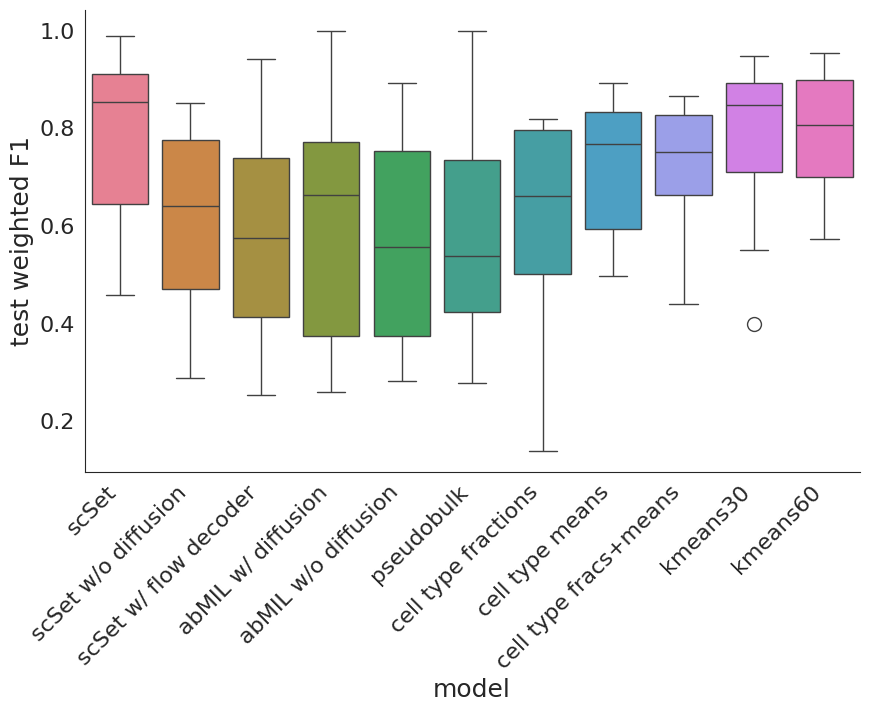

In [26]:
ax = sns.boxplot(results[(results.experiment=="linear probe") &(results.score>=0) & (results.metric=="test_weightedf1")], x="model", y="score", hue="model")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");
ax.set_ylabel("test weighted F1")
plt.savefig("figures/supervised_hlcatriple_test_weightedf1.png", bbox_inches="tight")

In [27]:
means = results[(results.metric.isin(["test_auc", "test_acc", "test_weightedf1"])) & (results.score>=0)].groupby(['experiment','model','metric']).score.mean().reset_index().sort_values(["experiment","model"])

/tmp/ipykernel_2741004/1879969921.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = results[(results.metric.isin(["test_auc", "test_acc", "test_weightedf1"])) & (results.score>=0)].groupby(['experiment','model','metric']).score.mean().reset_index().sort_values(["experiment","model"])


In [28]:
sems = results[(results.metric.isin(["test_auc", "test_acc", "test_weightedf1"])) & (results.score>=0)].groupby(
    ['experiment','model','metric']).score.apply(calc_sem).reset_index().sort_values(["experiment","model"])


/tmp/ipykernel_2741004/805102240.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sems = results[(results.metric.isin(["test_auc", "test_acc", "test_weightedf1"])) & (results.score>=0)].groupby(


In [29]:
cis = results[(results.metric.isin(["test_auc", "test_acc", "test_weightedf1"])) & (results.score>=0)].groupby(['experiment','model','metric']).score.apply(calc_95_ci).reset_index().sort_values(["experiment","model"])


/tmp/ipykernel_2741004/3185520529.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cis = results[(results.metric.isin(["test_auc", "test_acc", "test_weightedf1"])) & (results.score>=0)].groupby(['experiment','model','metric']).score.apply(calc_95_ci).reset_index().sort_values(["experiment","model"])


In [30]:
summarytable = means.merge(sems, on=['experiment','model','metric'], suffixes=('_mean','_sem'))
summarytable


,experiment,model,metric,score_mean,score_sem
0,linear probe,scSet,test_acc,0.746778,0.063352
1,linear probe,scSet,test_auc,0.888691,0.054047
2,linear probe,scSet,test_weightedf1,0.775450,0.057751
3,linear probe,scSet w/o diffusion,test_acc,0.608501,0.052827
4,linear probe,scSet w/o diffusion,test_auc,0.729033,0.067112
...,...,...,...,...,...
94,FT End-to-End,kmeans30,test_auc,NaN,NaN
95,FT End-to-End,kmeans30,test_weightedf1,NaN,NaN
96,FT End-to-End,kmeans60,test_acc,NaN,NaN
97,FT End-to-End,kmeans60,test_auc,NaN,NaN


In [31]:
summarytable['metric'] = summarytable['metric'].map({'test_auc':'AUC', 'test_acc':'Accuracy', 'test_weightedf1':'Weighted F1'})

In [32]:
summarytable['value'] = summarytable['score_mean'].round(2).astype(str) + r"$\pm$" + summarytable['score_sem'].round(2).astype(str)
summarytable.replace("nan$\pm$nan", "NaN", inplace=True)
summarytable

<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'


/tmp/ipykernel_2741004/2359185432.py:2: SyntaxWarning: invalid escape sequence '\p'
  summarytable.replace("nan$\pm$nan", "NaN", inplace=True)


,experiment,model,metric,score_mean,score_sem,value
0,linear probe,scSet,Accuracy,0.746778,0.063352,0.75$\pm$0.06
1,linear probe,scSet,AUC,0.888691,0.054047,0.89$\pm$0.05
2,linear probe,scSet,Weighted F1,0.775450,0.057751,0.78$\pm$0.06
3,linear probe,scSet w/o diffusion,Accuracy,0.608501,0.052827,0.61$\pm$0.05
4,linear probe,scSet w/o diffusion,AUC,0.729033,0.067112,0.73$\pm$0.07
...,...,...,...,...,...,...
94,FT End-to-End,kmeans30,AUC,NaN,NaN,NaN
95,FT End-to-End,kmeans30,Weighted F1,NaN,NaN,NaN
96,FT End-to-End,kmeans60,Accuracy,NaN,NaN,NaN
97,FT End-to-End,kmeans60,AUC,NaN,NaN,NaN


In [33]:
summarytable['dataset']="HLCA triple"
all_paper_res = pd.concat([all_paper_res, summarytable], axis=0)

In [34]:
summarytable = summarytable.pivot_table(index=['model'], columns=['metric','experiment'], values='value', aggfunc='first')
summarytable

/tmp/ipykernel_2741004/3474809966.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  summarytable = summarytable.pivot_table(index=['model'], columns=['metric','experiment'], values='value', aggfunc='first')


metric                           AUC                                \
experiment              linear probe            MLP  FT End-to-End   
model                                                                
scSet                  0.89$\pm$0.05  0.83$\pm$0.06  0.74$\pm$0.11   
scSet w/o diffusion    0.73$\pm$0.07  0.71$\pm$0.05  0.72$\pm$0.07   
scSet w/ flow decoder  0.73$\pm$0.07  0.66$\pm$0.06  0.73$\pm$0.07   
abMIL w/ diffusion     0.71$\pm$0.07   0.7$\pm$0.05  0.71$\pm$0.05   
abMIL w/o diffusion    0.71$\pm$0.07  0.68$\pm$0.05  0.73$\pm$0.05   
pseudobulk             0.71$\pm$0.06  0.62$\pm$0.05  0.64$\pm$0.05   
cell type fractions    0.79$\pm$0.04   0.74$\pm$0.1            NaN   
cell type means         0.9$\pm$0.03  0.84$\pm$0.05            NaN   
cell type fracs+means   0.9$\pm$0.03   0.8$\pm$0.06            NaN   
kmeans30               0.92$\pm$0.05  0.83$\pm$0.08            NaN   
kmeans60                0.9$\pm$0.03  0.79$\pm$0.07            NaN   

metric                      Accuracy                                \
experiment              linear probe            MLP  FT End-to-End   
model                                                                
scSet                  0.75$\pm$0.06  0.66$\pm$0.07  0.65$\pm$0.07   
scSet w/o diffusion    0.61$\pm$0.05  0.45$\pm$0.07  0.51$\pm$0.08   
scSet w/ flow decoder  0.58$\pm$0.06  0.49$\pm$0.09  0.55$\pm$0.07   
abMIL w/ diffusion     0.65$\pm$0.08  0.53$\pm$0.06  0.48$\pm$0.06   
abMIL w/o diffusion    0.58$\pm$0.06  0.39$\pm$0.06  0.49$\pm$0.06   
pseudobulk             0.62$\pm$0.07  0.44$\pm$0.05  0.46$\pm$0.04   
cell type fractions    0.58$\pm$0.06  0.47$\pm$0.09            NaN   
cell type means         0.7$\pm$0.04  0.63$\pm$0.04            NaN   
cell type fracs+means   0.7$\pm$0.04  0.66$\pm$0.05            NaN   
kmeans30               0.76$\pm$0.05  0.58$\pm$0.07            NaN   
kmeans60               0.78$\pm$0.04  0.63$\pm$0.07            NaN   

metric                   Weighted F1                                
experiment              linear probe            MLP  FT End-to-End  
model                                                               
scSet                  0.78$\pm$0.06  0.68$\pm$0.07  0.66$\pm$0.08  
scSet w/o diffusion    0.61$\pm$0.06  0.47$\pm$0.08  0.53$\pm$0.09  
scSet w/ flow decoder  0.57$\pm$0.07  0.43$\pm$0.09  0.57$\pm$0.07  
abMIL w/ diffusion     0.62$\pm$0.08  0.57$\pm$0.06  0.52$\pm$0.05  
abMIL w/o diffusion    0.57$\pm$0.07  0.38$\pm$0.07  0.52$\pm$0.06  
pseudobulk             0.58$\pm$0.07  0.49$\pm$0.06   0.5$\pm$0.05  
cell type fractions     0.6$\pm$0.07  0.51$\pm$0.09            NaN  
cell type means        0.73$\pm$0.04  0.68$\pm$0.04            NaN  
cell type fracs+means  0.72$\pm$0.04   0.7$\pm$0.05            NaN  
kmeans30               0.77$\pm$0.05  0.63$\pm$0.06            NaN  
kmeans60               0.79$\pm$0.04  0.66$\pm$0.06            NaN

In [35]:
latextable = summarytable.to_latex(index=True, escape=False)
print(latextable)

\begin{tabular}{llllllllll}
\toprule
metric & \multicolumn{3}{r}{AUC} & \multicolumn{3}{r}{Accuracy} & \multicolumn{3}{r}{Weighted F1} \\
experiment & linear probe & MLP & FT End-to-End & linear probe & MLP & FT End-to-End & linear probe & MLP & FT End-to-End \\
model &  &  &  &  &  &  &  &  &  \\
\midrule
scSet & 0.89$\pm$0.05 & 0.83$\pm$0.06 & 0.74$\pm$0.11 & 0.75$\pm$0.06 & 0.66$\pm$0.07 & 0.65$\pm$0.07 & 0.78$\pm$0.06 & 0.68$\pm$0.07 & 0.66$\pm$0.08 \\
scSet w/o diffusion & 0.73$\pm$0.07 & 0.71$\pm$0.05 & 0.72$\pm$0.07 & 0.61$\pm$0.05 & 0.45$\pm$0.07 & 0.51$\pm$0.08 & 0.61$\pm$0.06 & 0.47$\pm$0.08 & 0.53$\pm$0.09 \\
scSet w/ flow decoder & 0.73$\pm$0.07 & 0.66$\pm$0.06 & 0.73$\pm$0.07 & 0.58$\pm$0.06 & 0.49$\pm$0.09 & 0.55$\pm$0.07 & 0.57$\pm$0.07 & 0.43$\pm$0.09 & 0.57$\pm$0.07 \\
abMIL w/ diffusion & 0.71$\pm$0.07 & 0.7$\pm$0.05 & 0.71$\pm$0.05 & 0.65$\pm$0.08 & 0.53$\pm$0.06 & 0.48$\pm$0.06 & 0.62$\pm$0.08 & 0.57$\pm$0.06 & 0.52$\pm$0.05 \\
abMIL w/o diffusion & 0.71$\pm$0.07 & 

# SLE

#### make table for paper based on 14 latents

In [36]:
mytags = ['SLE_hvlatents', 'SLE_flowdecoder_newmlp_lr1e-5_finetune_final', 'additional_baseline_encoders', 'lupus_kmeans60']
                                      
df_subset = df[(df.tag.isin(mytags)) & (df.h5ad_loc=="/data/rna_rep_learning/perez2022_lupus/perez2022_merged_metadata_and_scvi_census20240701.h5ad")] # need the second condition because my additional_baseline_encoders tag is not unique to this dataset

In [37]:
results = load_results(results_dir='/data/rna_rep_learning/scset/outputs/results')

In [38]:
#limit results to those runs we selected in df_subset
results = results[results.run_name.isin(df_subset.run_name)]

In [39]:
results.experiment[results.experiment=="MLP"] = "supervised_frozen"

/tmp/ipykernel_2741004/67370319.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  results.experiment[results.experiment=="MLP"] = "supervised_frozen"


In [40]:
def add_columns_to_results(annotations, results, columns=['pretrain']):
    # add pretrain column to results using run_name column
    annotations = annotations.set_index('run_name')
    for col in columns:
        results[col] = results['run_name'].apply(lambda x: annotations.loc[x][col])

In [41]:
extra_annotation = ['tag','h5ad_loc', 'max_num_cells', 'cur_time', "lr"] #'model' was updated to 'encoder' on 10.14.24, will need to update this depending on when models were run
add_columns_to_results(df_subset, results, columns=extra_annotation)

In [42]:
# remove catfracmeans with tag "hlcatrinary_hvlatents" bc there was a bug - reran with additional_baseline_encoders tag
results = results[~((results.encoder == 'catfracsmeans') & (results.tag == 'SLE_hvlatents'))]

In [43]:
# differentiate between kmeans30 and kmeans60
results.loc[(results.encoder == 'kmeans') & (results.tag == 'lupus_kmeans60'), 'encoder'] = 'kmeans60'
results.loc[(results.encoder == 'kmeans') & (results.tag == 'additional_baseline_encoders'), 'encoder'] = 'kmeans30'

In [44]:
results.groupby(['encoder','pretrain','experiment','tag']).size().reset_index().sort_values(["encoder","pretrain"])

,encoder,pretrain,experiment,tag,0
0,abmil,diffusion,linear_probe,SLE_hvlatents,30
1,abmil,diffusion,supervised,SLE_hvlatents,120
2,abmil,diffusion,supervised_frozen,SLE_hvlatents,120
3,abmil,none,linear_probe,SLE_hvlatents,30
4,abmil,none,supervised,SLE_hvlatents,120
5,abmil,none,supervised_frozen,SLE_hvlatents,120
6,catfracsmeans,none,linear_probe,additional_baseline_encoders,30
7,catfracsmeans,none,supervised_frozen,additional_baseline_encoders,120
8,cell_transformer,diffusion,linear_probe,SLE_hvlatents,30
9,cell_transformer,diffusion,supervised,SLE_hvlatents,120


In [45]:
results['model'] = results.encoder + "_" + results.pretrain

In [46]:
results['model'] = results.model.map({'cell_transformer_diffusion':'scSet', 
                                   'abmil_diffusion':'abMIL w/ diffusion', 
                                   'abmil_none':'abMIL w/o diffusion',
                                   'cell_transformer_none':'scSet w/o diffusion',
                                   'cell_transformer_flow':'scSet w/ flow decoder', 
                                   'pseudo_bulk_none':'pseudobulk', #this may be none or diffusion depending on which was run for this dataset
                                   'celltypefracs_none':'cell type fractions', 
                                   'celltypemeans_none':'cell type means', 
                                   'catfracsmeans_none':'cell type fracs+means',
                                   'kmeans30_none':'kmeans30',
                                    'kmeans60_none':'kmeans60',
                                   })

In [47]:
results['experiment'] = results['experiment'].map({'linear_probe':'linear probe', 'supervised_frozen':'MLP', 'supervised':'FT End-to-End'})

In [48]:
results['model'] = pd.Categorical(
    results.model, categories=['scSet', 'scSet w/o diffusion', 'scSet w/ flow decoder', 'abMIL w/ diffusion', 'abMIL w/o diffusion',
                                   'pseudobulk','cell type fractions', 'cell type means','cell type fracs+means', 'kmeans30', 'kmeans60'], ordered=True
)

results['experiment'] = pd.Categorical(
    results.experiment, categories=["linear probe", "MLP", "FT End-to-End"], ordered=True
)

results = results.sort_values(["experiment","model"])

/tmp/ipykernel_2741004/767165177.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");


Text(0, 0.5, 'test weighted F1')

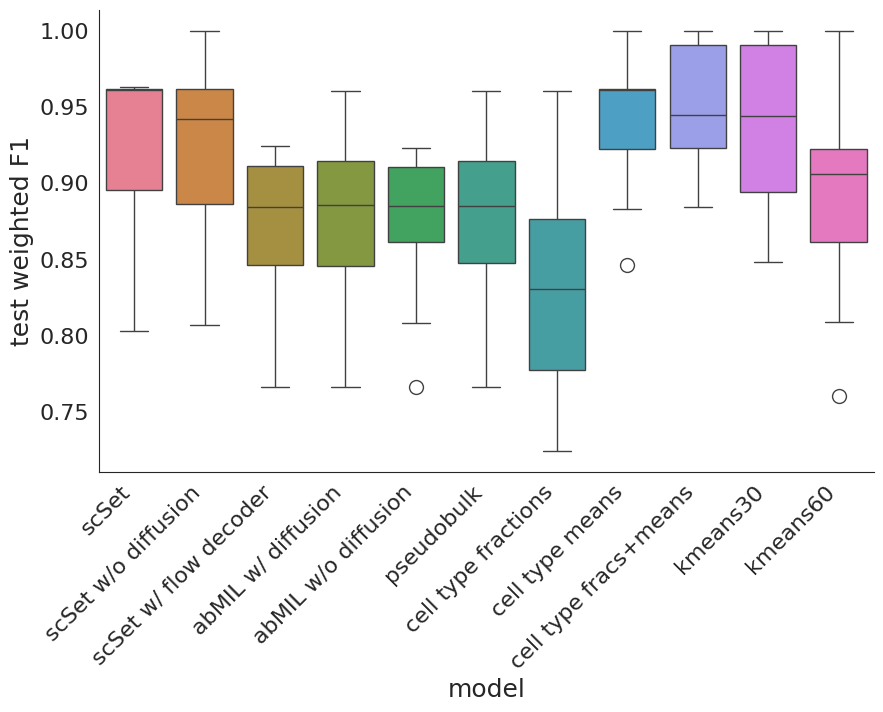

In [49]:
ax = sns.boxplot(results[(results.experiment=="linear probe") &(results.score>=0) & (results.metric=="test_weightedf1")], x="model", y="score", hue="model")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");
ax.set_ylabel("test weighted F1")
#plt.savefig("figures/supervised_SLE_test_weightedf1.png", bbox_inches="tight")

/tmp/ipykernel_2741004/3462137745.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");


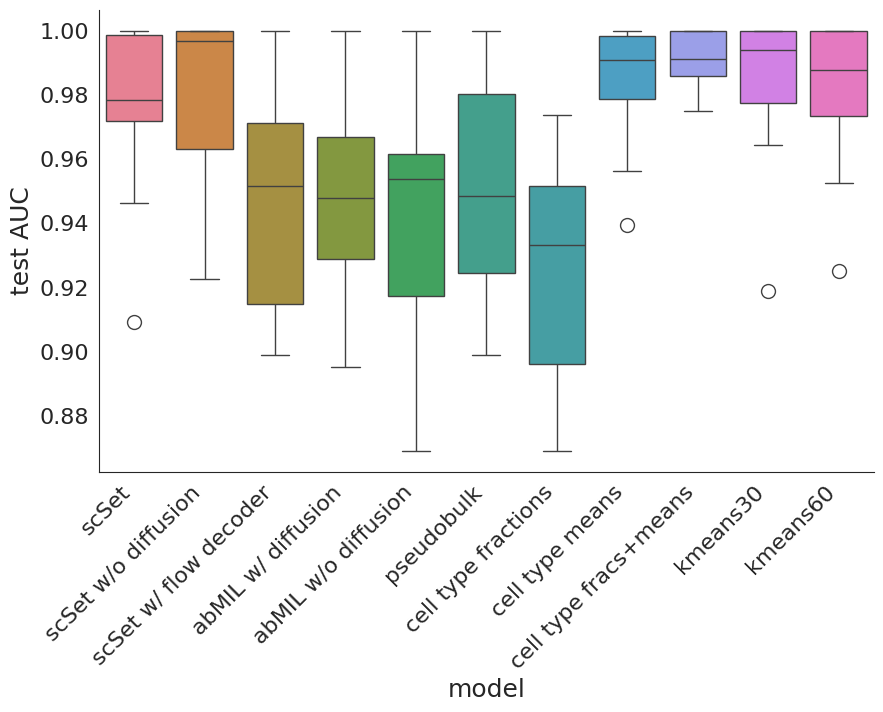

In [50]:
ax = sns.boxplot(results[(results.experiment=="linear probe") &(results.score>=0) & (results.metric=="test_auc")], x="model", y="score", hue="model")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");
ax.set_ylabel("test AUC")
plt.savefig("figures/supervised_SLE_testauc.png", bbox_inches="tight")

In [51]:
means = results[(results.metric.isin(["test_auc", "test_acc", "test_weightedf1"])) & (results.score>=0)].groupby(['experiment','model','metric']).score.mean().reset_index().sort_values(["experiment","model"])
cis = results[(results.metric.isin(["test_auc", "test_acc", "test_weightedf1"])) & (results.score>=0)].groupby(['experiment','model','metric']).score.apply(calc_95_ci).reset_index().sort_values(["experiment","model"])
sems = results[(results.metric.isin(["test_auc", "test_acc", "test_weightedf1"])) & (results.score>=0)].groupby(['experiment','model','metric']).score.apply(calc_sem).reset_index().sort_values(["experiment","model"])

/tmp/ipykernel_2741004/2600472290.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = results[(results.metric.isin(["test_auc", "test_acc", "test_weightedf1"])) & (results.score>=0)].groupby(['experiment','model','metric']).score.mean().reset_index().sort_values(["experiment","model"])
/tmp/ipykernel_2741004/2600472290.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cis = results[(results.metric.isin(["test_auc", "test_acc", "test_weightedf1"])) & (results.score>=0)].groupby(['experiment','model','metric']).score.apply(calc_95_ci).reset_index().sort_values(["experiment","model"])
/tmp/ipykernel_27

In [52]:
summarytable = means.merge(sems, on=['experiment','model','metric'], suffixes=('_mean','_sem'))
summarytable['metric'] = summarytable['metric'].map({'test_auc':'AUC', 'test_acc':'Accuracy', 'test_weightedf1':'Weighted F1'})
summarytable['value'] = summarytable['score_mean'].round(2).astype(str) + r"$\pm$" + summarytable['score_sem'].round(2).astype(str)
summarytable.replace("nan$\pm$nan", "NaN", inplace=True)

<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_2741004/3588812175.py:4: SyntaxWarning: invalid escape sequence '\p'
  summarytable.replace("nan$\pm$nan", "NaN", inplace=True)


In [53]:
summarytable['dataset']="SLE"
all_paper_res = pd.concat([all_paper_res, summarytable], axis=0)

In [54]:
summarytable = summarytable.pivot_table(index=['model'], columns=['metric','experiment'], values='value', aggfunc='first')

/tmp/ipykernel_2741004/1620155347.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  summarytable = summarytable.pivot_table(index=['model'], columns=['metric','experiment'], values='value', aggfunc='first')


In [55]:
latextable = summarytable.to_latex(index=True, escape=False)
print(latextable)

\begin{tabular}{llllllllll}
\toprule
metric & \multicolumn{3}{r}{AUC} & \multicolumn{3}{r}{Accuracy} & \multicolumn{3}{r}{Weighted F1} \\
experiment & linear probe & MLP & FT End-to-End & linear probe & MLP & FT End-to-End & linear probe & MLP & FT End-to-End \\
model &  &  &  &  &  &  &  &  &  \\
\midrule
scSet & 0.98$\pm$0.01 & 0.98$\pm$0.01 & 0.99$\pm$0.0 & 0.93$\pm$0.02 & 0.94$\pm$0.01 & 0.95$\pm$0.01 & 0.93$\pm$0.02 & 0.94$\pm$0.01 & 0.95$\pm$0.01 \\
scSet w/o diffusion & 0.98$\pm$0.01 & 0.95$\pm$0.02 & 0.97$\pm$0.01 & 0.92$\pm$0.02 & 0.84$\pm$0.03 & 0.92$\pm$0.02 & 0.92$\pm$0.02 & 0.83$\pm$0.04 & 0.92$\pm$0.02 \\
scSet w/ flow decoder & 0.95$\pm$0.01 & 0.88$\pm$0.02 & 0.97$\pm$0.01 & 0.87$\pm$0.02 & 0.77$\pm$0.04 & 0.92$\pm$0.02 & 0.87$\pm$0.02 & 0.76$\pm$0.04 & 0.92$\pm$0.01 \\
abMIL w/ diffusion & 0.95$\pm$0.01 & 0.95$\pm$0.02 & 0.96$\pm$0.01 & 0.87$\pm$0.02 & 0.9$\pm$0.01 & 0.92$\pm$0.01 & 0.87$\pm$0.02 & 0.9$\pm$0.01 & 0.92$\pm$0.01 \\
abMIL w/o diffusion & 0.94$\pm$0.01 & 0.

# COVID binary

#### make table for paper based on 14 latents

In [56]:
mytags = ['covidbinary_hvlatents', 'covidbinary_flowdecoder_newmlp_lr1e-5_finetune_final', 'additional_baseline_encoders', 'covidbinary_kmeans60']
                                      
df_subset = df[(df.tag.isin(mytags)) & (df.h5ad_loc=="/data/rna_rep_learning/covid_stephenson2021/covid_stephenson_covid_vs_healthy_unbalanced.h5ad")] # need the second condition because my additional_baseline_encoders tag is not unique to this dataset

In [57]:
results = load_results(results_dir='/data/rna_rep_learning/scset/outputs/results')

In [58]:
#limit results to those runs we selected in df_subset
results = results[results.run_name.isin(df_subset.run_name)]

In [59]:
results.experiment[results.experiment=="MLP"] = "supervised_frozen"

/tmp/ipykernel_2741004/67370319.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  results.experiment[results.experiment=="MLP"] = "supervised_frozen"


In [60]:
def add_columns_to_results(annotations, results, columns=['pretrain']):
    # add pretrain column to results using run_name column
    annotations = annotations.set_index('run_name')
    for col in columns:
        results[col] = results['run_name'].apply(lambda x: annotations.loc[x][col])

In [61]:
extra_annotation = ['tag','h5ad_loc', 'max_num_cells', 'cur_time', "lr"] #'model' was updated to 'encoder' on 10.14.24, will need to update this depending on when models were run
add_columns_to_results(df_subset, results, columns=extra_annotation)

In [62]:
results = results[~((results.encoder == 'catfracsmeans') & (results.tag == 'covidbinary_hvlatents'))] # remove catfracmeans with tag "covidbinary_hvlatents" bc there was a bug - reran with additional_baseline_encoders tag

In [63]:
# differentiate between kmeans30 and kmeans60
results.loc[(results.encoder == 'kmeans') & (results.tag == 'covidbinary_kmeans60'), 'encoder'] = 'kmeans60'
results.loc[(results.encoder == 'kmeans') & (results.tag == 'additional_baseline_encoders'), 'encoder'] = 'kmeans30'

In [64]:
results.groupby(['encoder','pretrain','experiment','tag']).size().reset_index().sort_values(["encoder","pretrain"])

,encoder,pretrain,experiment,tag,0
0,abmil,diffusion,linear_probe,covidbinary_hvlatents,30
1,abmil,diffusion,supervised,covidbinary_hvlatents,120
2,abmil,diffusion,supervised_frozen,covidbinary_hvlatents,120
3,abmil,none,linear_probe,covidbinary_hvlatents,30
4,abmil,none,supervised,covidbinary_hvlatents,120
5,abmil,none,supervised_frozen,covidbinary_hvlatents,120
6,catfracsmeans,none,linear_probe,additional_baseline_encoders,30
7,catfracsmeans,none,supervised_frozen,additional_baseline_encoders,120
8,cell_transformer,diffusion,linear_probe,covidbinary_hvlatents,30
9,cell_transformer,diffusion,supervised,covidbinary_hvlatents,120


In [65]:
results['model'] = results.encoder + "_" + results.pretrain

In [66]:
results['model'] = results.model.map({'cell_transformer_diffusion':'scSet', 
                                   'abmil_diffusion':'abMIL w/ diffusion', 
                                   'abmil_none':'abMIL w/o diffusion',
                                   'cell_transformer_none':'scSet w/o diffusion',
                                   'cell_transformer_flow':'scSet w/ flow decoder', 
                                   'pseudo_bulk_none':'pseudobulk', #check if this should be none or diffusion for each dataset
                                   'celltypefracs_none':'cell type fractions', 
                                   'celltypemeans_none':'cell type means', 
                                   'catfracsmeans_none':'cell type fracs+means',
                                   'kmeans30_none':'kmeans30',
                                      'kmeans60_none':'kmeans60',
                                   })

In [67]:
results['experiment'] = results['experiment'].map({'linear_probe':'linear probe', 'supervised_frozen':'MLP', 'supervised':'FT End-to-End'})

In [68]:
results['model'] = pd.Categorical(
    results.model, categories=['scSet', 'scSet w/o diffusion', 'scSet w/ flow decoder', 'abMIL w/ diffusion', 'abMIL w/o diffusion',
                                   'pseudobulk','cell type fractions', 'cell type means','cell type fracs+means', 'kmeans30', 'kmeans60'], ordered=True
)

results['experiment'] = pd.Categorical(
    results.experiment, categories=["linear probe", "MLP", "FT End-to-End"], ordered=True
)

results = results.sort_values(["experiment","model"])

/tmp/ipykernel_2741004/2454343928.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");


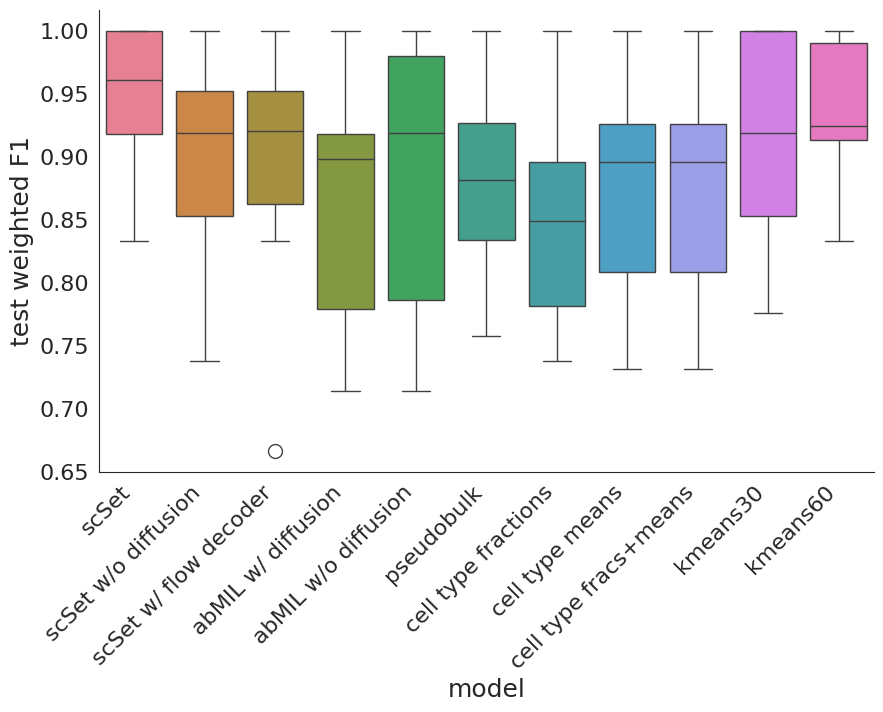

In [69]:
ax = sns.boxplot(results[(results.experiment=="linear probe") &(results.score>=0) & (results.metric=="test_weightedf1")], x="model", y="score", hue="model")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");
ax.set_ylabel("test weighted F1")
plt.savefig("figures/supervised_covidbinary_test_weightedf1.png", bbox_inches="tight")

/tmp/ipykernel_2741004/1142850180.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");


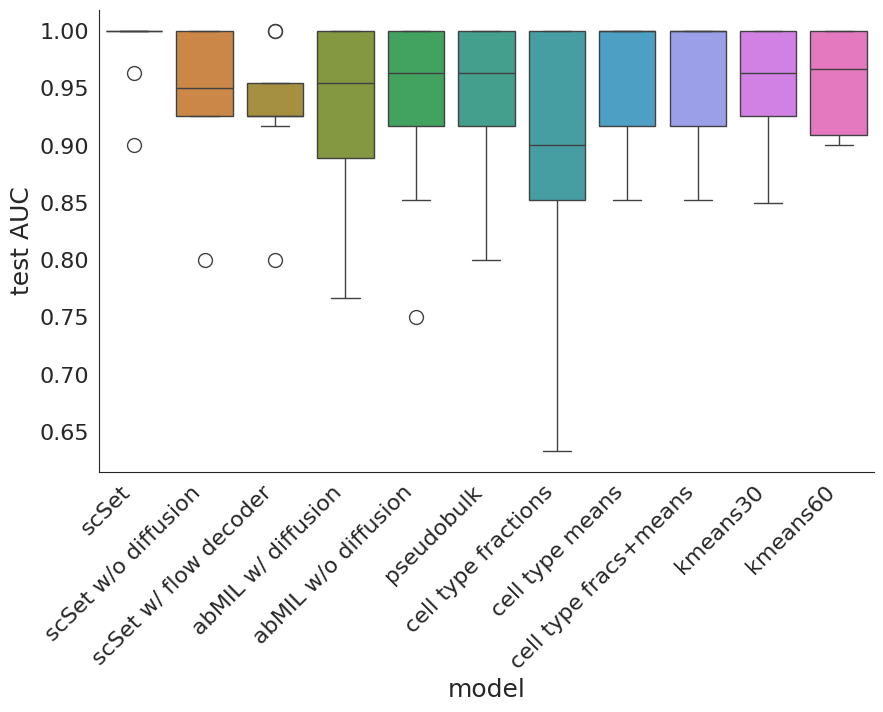

In [70]:
ax = sns.boxplot(results[(results.experiment=="linear probe") &(results.score>=0) & (results.metric=="test_auc")], x="model", y="score", hue="model")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");
ax.set_ylabel("test AUC")
plt.savefig("figures/supervised_covidbinary_testauc.png", bbox_inches="tight")

In [71]:
means = results[(results.metric.isin(["test_auc", "test_acc", "test_weightedf1"])) & (results.score>=0)].groupby(['experiment','model','metric']).score.mean().reset_index().sort_values(["experiment","model"])
cis = results[(results.metric.isin(["test_auc", "test_acc", "test_weightedf1"])) & (results.score>=0)].groupby(['experiment','model','metric']).score.apply(calc_95_ci).reset_index().sort_values(["experiment","model"])
sems = results[(results.metric.isin(["test_auc", "test_acc", "test_weightedf1"])) & (results.score>=0)].groupby(['experiment','model','metric']).score.apply(calc_sem).reset_index().sort_values(["experiment","model"])


/tmp/ipykernel_2741004/2621643868.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = results[(results.metric.isin(["test_auc", "test_acc", "test_weightedf1"])) & (results.score>=0)].groupby(['experiment','model','metric']).score.mean().reset_index().sort_values(["experiment","model"])
/tmp/ipykernel_2741004/2621643868.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cis = results[(results.metric.isin(["test_auc", "test_acc", "test_weightedf1"])) & (results.score>=0)].groupby(['experiment','model','metric']).score.apply(calc_95_ci).reset_index().sort_values(["experiment","model"])
/tmp/ipykernel_27

In [72]:
summarytable = means.merge(sems, on=['experiment','model','metric'], suffixes=('_mean','_sem'))
summarytable['metric'] = summarytable['metric'].map({'test_auc':'AUC', 'test_acc':'Accuracy', 'test_weightedf1':'Weighted F1'})
summarytable['value'] = summarytable['score_mean'].round(2).astype(str) + r"$\pm$" + summarytable['score_sem'].round(2).astype(str)
summarytable.replace("nan$\pm$nan", "NaN", inplace=True)

<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_2741004/3588812175.py:4: SyntaxWarning: invalid escape sequence '\p'
  summarytable.replace("nan$\pm$nan", "NaN", inplace=True)


In [73]:
summarytable['dataset']="COVID binary"
all_paper_res = pd.concat([all_paper_res, summarytable], axis=0)

In [74]:
summarytable = summarytable.pivot_table(index=['model'], columns=['metric','experiment'], values='value', aggfunc='first')


/tmp/ipykernel_2741004/1753419296.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  summarytable = summarytable.pivot_table(index=['model'], columns=['metric','experiment'], values='value', aggfunc='first')


In [75]:
latextable = summarytable.to_latex(index=True, escape=False)
print(latextable)

\begin{tabular}{llllllllll}
\toprule
metric & \multicolumn{3}{r}{AUC} & \multicolumn{3}{r}{Accuracy} & \multicolumn{3}{r}{Weighted F1} \\
experiment & linear probe & MLP & FT End-to-End & linear probe & MLP & FT End-to-End & linear probe & MLP & FT End-to-End \\
model &  &  &  &  &  &  &  &  &  \\
\midrule
scSet & 0.98$\pm$0.01 & 0.98$\pm$0.02 & 0.98$\pm$0.01 & 0.95$\pm$0.02 & 0.93$\pm$0.02 & 0.92$\pm$0.02 & 0.95$\pm$0.02 & 0.93$\pm$0.02 & 0.93$\pm$0.02 \\
scSet w/o diffusion & 0.95$\pm$0.02 & 0.96$\pm$0.02 & 0.82$\pm$0.1 & 0.9$\pm$0.02 & 0.86$\pm$0.02 & 0.88$\pm$0.03 & 0.9$\pm$0.03 & 0.86$\pm$0.02 & 0.88$\pm$0.03 \\
scSet w/ flow decoder & 0.93$\pm$0.02 & 0.79$\pm$0.04 & 0.94$\pm$0.05 & 0.89$\pm$0.03 & 0.75$\pm$0.02 & 0.86$\pm$0.03 & 0.9$\pm$0.03 & 0.71$\pm$0.04 & 0.87$\pm$0.03 \\
abMIL w/ diffusion & 0.92$\pm$0.03 & 0.86$\pm$0.06 & 0.88$\pm$0.06 & 0.88$\pm$0.03 & 0.83$\pm$0.03 & 0.85$\pm$0.03 & 0.87$\pm$0.03 & 0.83$\pm$0.03 & 0.85$\pm$0.03 \\
abMIL w/o diffusion & 0.93$\pm$0.03 & 0.9

# HCLA binary - confidence intervals are huge on auc/F1 bc only 4 eligible folds. Leave out.

#### make table for paper based on 14 latents

In [76]:
mytags = ['hlcabinary_hvlatents', 'hlcabinary_flowdecoder_newmlp_lr1e-5_finetune_final', 'additional_baseline_encoders', 'hlcabinary_kmeans60']
                                      
df_subset = df[(df.tag.isin(mytags)) & (df.h5ad_loc=="/data/rna_rep_learning/hlca_sikkema2023/hlca_sikkema2023_IPFnormal_unbalanced_n287_cxgcensus20240701.h5ad")]

In [77]:
results = load_results(results_dir='/data/rna_rep_learning/scset/outputs/results')

In [78]:
#limit results to those runs we selected in df_subset
results = results[results.run_name.isin(df_subset.run_name)]

In [79]:
results.experiment[results.experiment=="MLP"] = "supervised_frozen"

/tmp/ipykernel_2741004/67370319.py:1: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  results.experiment[results.experiment=="MLP"] = "supervised_frozen"


In [80]:
def add_columns_to_results(annotations, results, columns=['pretrain']):
    # add pretrain column to results using run_name column
    annotations = annotations.set_index('run_name')
    for col in columns:
        results[col] = results['run_name'].apply(lambda x: annotations.loc[x][col])

In [81]:
extra_annotation = ['tag','h5ad_loc', 'max_num_cells', 'cur_time', "lr"] #'model' was updated to 'encoder' on 10.14.24, will need to update this depending on when models were run
add_columns_to_results(df_subset, results, columns=extra_annotation)

In [82]:
# remove buggy catfracmeans run
results = results[~((results.encoder == 'catfracsmeans') & (results.tag == 'hlcabinary_hvlatents'))] # remove catfracmeans with tag "covidbinary_hvlatents" bc there was a bug - reran with additional_baseline_encoders tag

In [83]:
# differentiate between kmeans30 and kmeans60
results.loc[(results.encoder == 'kmeans') & (results.tag == 'hlcabinary_kmeans60'), 'encoder'] = 'kmeans60'
results.loc[(results.encoder == 'kmeans') & (results.tag == 'additional_baseline_encoders'), 'encoder'] = 'kmeans30'

In [84]:
results.groupby(['encoder','pretrain','experiment','tag']).size().reset_index().sort_values(["encoder","pretrain"])

,encoder,pretrain,experiment,tag,0
0,abmil,diffusion,linear_probe,hlcabinary_hvlatents,30
1,abmil,diffusion,supervised,hlcabinary_hvlatents,120
2,abmil,diffusion,supervised_frozen,hlcabinary_hvlatents,120
3,abmil,none,linear_probe,hlcabinary_hvlatents,30
4,abmil,none,supervised,hlcabinary_hvlatents,120
5,abmil,none,supervised_frozen,hlcabinary_hvlatents,120
6,catfracsmeans,none,linear_probe,additional_baseline_encoders,30
7,catfracsmeans,none,supervised_frozen,additional_baseline_encoders,120
8,cell_transformer,diffusion,linear_probe,hlcabinary_hvlatents,30
9,cell_transformer,diffusion,supervised,hlcabinary_hvlatents,120


In [85]:
results['model'] = results.encoder + "_" + results.pretrain

In [86]:
results['model'] = results.model.map({'cell_transformer_diffusion':'scSet', 
                                   'abmil_diffusion':'abMIL w/ diffusion', 
                                   'abmil_none':'abMIL w/o diffusion',
                                   'cell_transformer_none':'scSet w/o diffusion', 
                                   'cell_transformer_flow':'scSet w/ flow decoder', 
                                   'pseudo_bulk_diffusion':'pseudobulk',
                                   'pseudo_bulk_none':'pseudobulk',
                                   'celltypefracs_none':'cell type fractions', 
                                   'celltypemeans_none':'cell type means', 
                                   'catfracsmeans_none':'cell type fracs+means',
                                   'kmeans30_none':'kmeans30',
                                      'kmeans60_none':'kmeans60',
                                   })

In [87]:
results['experiment'] = results['experiment'].map({'linear_probe':'linear probe', 'supervised_frozen':'MLP', 'supervised':'FT End-to-End'})

In [88]:
results['model'] = pd.Categorical(
    results.model, categories=['scSet', 'scSet w/o diffusion', 'scSet w/ flow decoder', 'abMIL w/ diffusion', 'abMIL w/o diffusion',
                                   'pseudobulk','cell type fractions', 'cell type means','cell type fracs+means', 'kmeans30', 'kmeans60'], ordered=True
)

results['experiment'] = pd.Categorical(
    results.experiment, categories=["linear probe", "MLP", "FT End-to-End"], ordered=True
)

results = results.sort_values(["experiment","model"])

/tmp/ipykernel_2741004/543933406.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");


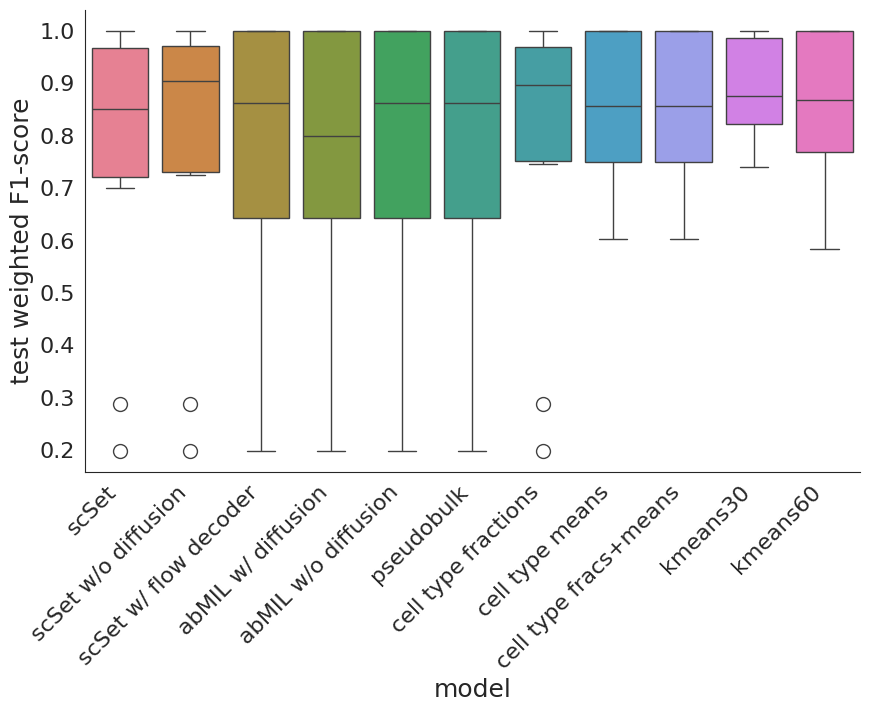

In [89]:
ax = sns.boxplot(results[(results.experiment=="linear probe") &(results.score>=0) & (results.metric=="test_weightedf1")], x="model", y="score", hue="model")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");
ax.set_ylabel("test weighted F1-score")
plt.savefig("figures/supervised_hlcabinary_test_weightedf1.png", bbox_inches="tight")

/tmp/ipykernel_2741004/4244912386.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");


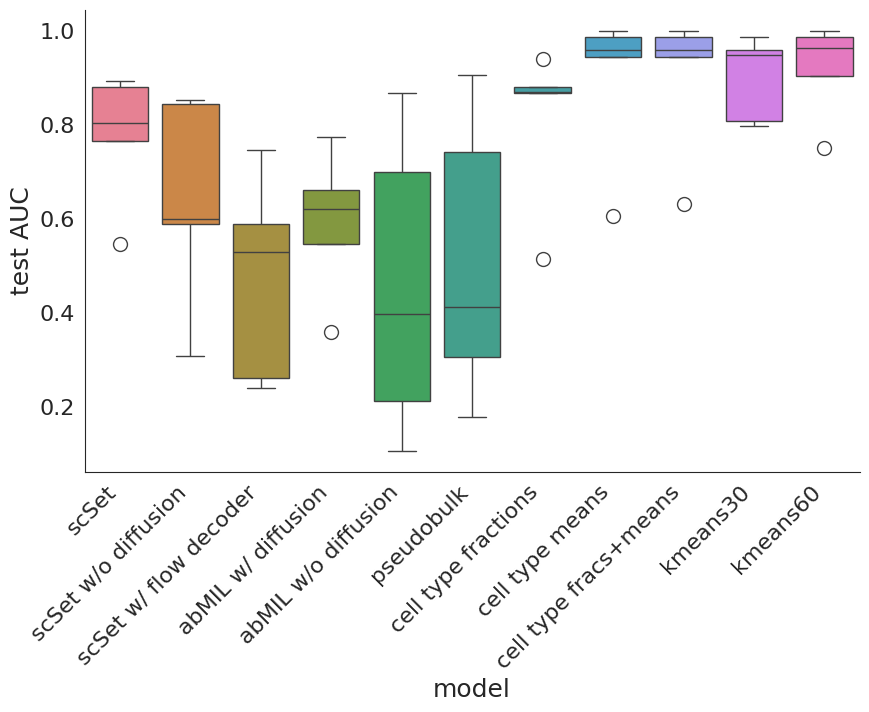

In [90]:
ax = sns.boxplot(results[(results.experiment=="linear probe") &(results.score>=0) & (results.metric=="test_auc")], x="model", y="score", hue="model")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right");
ax.set_ylabel("test AUC")
plt.savefig("figures/supervised_hlcabinary_testauc.png", bbox_inches="tight")

In [91]:
means = results[(results.metric.isin(["test_auc", "test_acc", "test_weightedf1"])) & (results.score>=0)].groupby(['experiment','model','metric']).score.mean().reset_index().sort_values(["experiment","model"])
#cis = results[(results.metric.isin(["test_auc", "test_acc", "test_weightedf1"])) & (results.score>=0)].groupby(['experiment','model','metric']).score.std().reset_index().sort_values(["experiment","model"])
cis = results[(results.metric.isin(["test_auc", "test_acc", "test_weightedf1"])) & (results.score>=0)].groupby(['experiment','model','metric']).score.apply(calc_95_ci).reset_index().sort_values(["experiment","model"])
sems = results[(results.metric.isin(["test_auc", "test_acc", "test_weightedf1"])) & (results.score>=0)].groupby(['experiment','model','metric']).score.apply(calc_sem).reset_index().sort_values(["experiment","model"])



/tmp/ipykernel_2741004/2781947079.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = results[(results.metric.isin(["test_auc", "test_acc", "test_weightedf1"])) & (results.score>=0)].groupby(['experiment','model','metric']).score.mean().reset_index().sort_values(["experiment","model"])
/tmp/ipykernel_2741004/2781947079.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cis = results[(results.metric.isin(["test_auc", "test_acc", "test_weightedf1"])) & (results.score>=0)].groupby(['experiment','model','metric']).score.apply(calc_95_ci).reset_index().sort_values(["experiment","model"])
/tmp/ipykernel_27

In [92]:
summarytable = means.merge(sems, on=['experiment','model','metric'], suffixes=('_mean','_sem'))
summarytable['metric'] = summarytable['metric'].map({'test_auc':'AUC', 'test_acc':'Accuracy', 'test_weightedf1':'Weighted F1'})
summarytable['value'] = summarytable['score_mean'].round(2).astype(str) + r"$\pm$" + summarytable['score_sem'].round(2).astype(str)
summarytable.replace("nan$\pm$nan", "NaN", inplace=True)

<>:4: SyntaxWarning: invalid escape sequence '\p'
<>:4: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_2741004/3588812175.py:4: SyntaxWarning: invalid escape sequence '\p'
  summarytable.replace("nan$\pm$nan", "NaN", inplace=True)


In [93]:
summarytable['dataset']="HLCA binary"
all_paper_res = pd.concat([all_paper_res, summarytable], axis=0)

In [94]:
summarytable = summarytable.pivot_table(index=['model'], columns=['metric','experiment'], values='value', aggfunc='first')


/tmp/ipykernel_2741004/1753419296.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  summarytable = summarytable.pivot_table(index=['model'], columns=['metric','experiment'], values='value', aggfunc='first')


In [95]:
latextable = summarytable.to_latex(index=True, escape=False)
print(latextable)

\begin{tabular}{llllllllll}
\toprule
metric & \multicolumn{3}{r}{AUC} & \multicolumn{3}{r}{Accuracy} & \multicolumn{3}{r}{Weighted F1} \\
experiment & linear probe & MLP & FT End-to-End & linear probe & MLP & FT End-to-End & linear probe & MLP & FT End-to-End \\
model &  &  &  &  &  &  &  &  &  \\
\midrule
scSet & 0.78$\pm$0.06 & 0.81$\pm$0.06 & 0.85$\pm$0.03 & 0.78$\pm$0.06 & 0.87$\pm$0.04 & 0.83$\pm$0.06 & 0.76$\pm$0.09 & 0.87$\pm$0.04 & 0.83$\pm$0.06 \\
scSet w/o diffusion & 0.64$\pm$0.09 & 0.58$\pm$0.1 & 0.71$\pm$0.08 & 0.8$\pm$0.07 & 0.71$\pm$0.07 & 0.81$\pm$0.06 & 0.77$\pm$0.09 & 0.73$\pm$0.06 & 0.82$\pm$0.06 \\
scSet w/ flow decoder & 0.47$\pm$0.09 & 0.48$\pm$0.15 & 0.73$\pm$0.04 & 0.81$\pm$0.07 & 0.72$\pm$0.1 & 0.84$\pm$0.04 & 0.75$\pm$0.09 & 0.67$\pm$0.11 & 0.85$\pm$0.04 \\
abMIL w/ diffusion & 0.59$\pm$0.06 & 0.66$\pm$0.08 & 0.68$\pm$0.06 & 0.79$\pm$0.07 & 0.77$\pm$0.07 & 0.79$\pm$0.05 & 0.74$\pm$0.09 & 0.78$\pm$0.07 & 0.78$\pm$0.06 \\
abMIL w/o diffusion & 0.46$\pm$0.13 & 0.

# Main paper for table, with results from all tasks

In [96]:
full_summary_f1 = all_paper_res[all_paper_res.metric=="Weighted F1"].pivot_table(index=['model'], columns=['dataset','experiment'], values='value', aggfunc='first')
full_summary_f1

/tmp/ipykernel_2741004/3787373495.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  full_summary_f1 = all_paper_res[all_paper_res.metric=="Weighted F1"].pivot_table(index=['model'], columns=['dataset','experiment'], values='value', aggfunc='first')


dataset                 COVID binary                                \
experiment              linear probe            MLP  FT End-to-End   
model                                                                
scSet                  0.95$\pm$0.02  0.93$\pm$0.02  0.93$\pm$0.02   
scSet w/o diffusion     0.9$\pm$0.03  0.86$\pm$0.02  0.88$\pm$0.03   
scSet w/ flow decoder   0.9$\pm$0.03  0.71$\pm$0.04  0.87$\pm$0.03   
abMIL w/ diffusion     0.87$\pm$0.03  0.83$\pm$0.03  0.85$\pm$0.03   
abMIL w/o diffusion    0.88$\pm$0.03  0.86$\pm$0.03  0.84$\pm$0.03   
pseudobulk             0.88$\pm$0.02   0.8$\pm$0.04  0.81$\pm$0.04   
cell type fractions    0.84$\pm$0.02  0.68$\pm$0.04            NaN   
cell type means        0.87$\pm$0.03  0.92$\pm$0.03            NaN   
cell type fracs+means  0.87$\pm$0.03  0.92$\pm$0.03            NaN   
kmeans30               0.92$\pm$0.03  0.86$\pm$0.04            NaN   
kmeans60               0.94$\pm$0.02   0.9$\pm$0.02            NaN   

dataset                  HLCA binary                                \
experiment              linear probe            MLP  FT End-to-End   
model                                                                
scSet                  0.76$\pm$0.09  0.87$\pm$0.04  0.83$\pm$0.06   
scSet w/o diffusion    0.77$\pm$0.09  0.73$\pm$0.06  0.82$\pm$0.06   
scSet w/ flow decoder  0.75$\pm$0.09  0.67$\pm$0.11  0.85$\pm$0.04   
abMIL w/ diffusion     0.74$\pm$0.09  0.78$\pm$0.07  0.78$\pm$0.06   
abMIL w/o diffusion    0.75$\pm$0.09   0.7$\pm$0.08   0.7$\pm$0.07   
pseudobulk             0.75$\pm$0.09  0.73$\pm$0.06  0.67$\pm$0.05   
cell type fractions    0.77$\pm$0.09  0.73$\pm$0.07            NaN   
cell type means        0.85$\pm$0.05  0.76$\pm$0.06            NaN   
cell type fracs+means  0.85$\pm$0.05  0.82$\pm$0.04            NaN   
kmeans30               0.89$\pm$0.03  0.87$\pm$0.04            NaN   
kmeans60               0.86$\pm$0.04  0.83$\pm$0.04            NaN   

dataset                  HLCA triple                                \
experiment              linear probe            MLP  FT End-to-End   
model                                                                
scSet                  0.78$\pm$0.06  0.68$\pm$0.07  0.66$\pm$0.08   
scSet w/o diffusion    0.61$\pm$0.06  0.47$\pm$0.08  0.53$\pm$0.09   
scSet w/ flow decoder  0.57$\pm$0.07  0.43$\pm$0.09  0.57$\pm$0.07   
abMIL w/ diffusion     0.62$\pm$0.08  0.57$\pm$0.06  0.52$\pm$0.05   
abMIL w/o diffusion    0.57$\pm$0.07  0.38$\pm$0.07  0.52$\pm$0.06   
pseudobulk             0.58$\pm$0.07  0.49$\pm$0.06   0.5$\pm$0.05   
cell type fractions     0.6$\pm$0.07  0.51$\pm$0.09            NaN   
cell type means        0.73$\pm$0.04  0.68$\pm$0.04            NaN   
cell type fracs+means  0.72$\pm$0.04   0.7$\pm$0.05            NaN   
kmeans30               0.77$\pm$0.05  0.63$\pm$0.06            NaN   
kmeans60               0.79$\pm$0.04  0.66$\pm$0.06            NaN   

dataset                          SLE                                
experiment              linear probe            MLP  FT End-to-End  
model                                                               
scSet                  0.93$\pm$0.02  0.94$\pm$0.01  0.95$\pm$0.01  
scSet w/o diffusion    0.92$\pm$0.02  0.83$\pm$0.04  0.92$\pm$0.02  
scSet w/ flow decoder  0.87$\pm$0.02  0.76$\pm$0.04  0.92$\pm$0.01  
abMIL w/ diffusion     0.87$\pm$0.02   0.9$\pm$0.01  0.92$\pm$0.01  
abMIL w/o diffusion    0.87$\pm$0.02  0.82$\pm$0.01   0.9$\pm$0.02  
pseudobulk             0.88$\pm$0.02  0.75$\pm$0.03  0.77$\pm$0.03  
cell type fractions    0.83$\pm$0.02  0.72$\pm$0.03            NaN  
cell type means        0.94$\pm$0.01  0.86$\pm$0.03            NaN  
cell type fracs+means  0.95$\pm$0.01   0.9$\pm$0.02            NaN  
kmeans30               0.94$\pm$0.02  0.92$\pm$0.02            NaN  
kmeans60               0.89$\pm$0.02  0.92$\pm$0.01            NaN

In [97]:
latextable = full_summary_f1.to_latex(index=True, escape=False)
print(latextable)


\begin{tabular}{lllllllllllll}
\toprule
dataset & \multicolumn{3}{r}{COVID binary} & \multicolumn{3}{r}{HLCA binary} & \multicolumn{3}{r}{HLCA triple} & \multicolumn{3}{r}{SLE} \\
experiment & linear probe & MLP & FT End-to-End & linear probe & MLP & FT End-to-End & linear probe & MLP & FT End-to-End & linear probe & MLP & FT End-to-End \\
model &  &  &  &  &  &  &  &  &  &  &  &  \\
\midrule
scSet & 0.95$\pm$0.02 & 0.93$\pm$0.02 & 0.93$\pm$0.02 & 0.76$\pm$0.09 & 0.87$\pm$0.04 & 0.83$\pm$0.06 & 0.78$\pm$0.06 & 0.68$\pm$0.07 & 0.66$\pm$0.08 & 0.93$\pm$0.02 & 0.94$\pm$0.01 & 0.95$\pm$0.01 \\
scSet w/o diffusion & 0.9$\pm$0.03 & 0.86$\pm$0.02 & 0.88$\pm$0.03 & 0.77$\pm$0.09 & 0.73$\pm$0.06 & 0.82$\pm$0.06 & 0.61$\pm$0.06 & 0.47$\pm$0.08 & 0.53$\pm$0.09 & 0.92$\pm$0.02 & 0.83$\pm$0.04 & 0.92$\pm$0.02 \\
scSet w/ flow decoder & 0.9$\pm$0.03 & 0.71$\pm$0.04 & 0.87$\pm$0.03 & 0.75$\pm$0.09 & 0.67$\pm$0.11 & 0.85$\pm$0.04 & 0.57$\pm$0.07 & 0.43$\pm$0.09 & 0.57$\pm$0.07 & 0.87$\pm$0.02 & 0.76$\

In [ ]:
# get just covid, hlca triple, and SLE for main table
print(full_summary_f1.loc[:, (['COVID binary', 'HLCA triple', 'SLE'], slice(None))].to_latex(index=True, escape=False))

\begin{tabular}{llllllllll}
\toprule
dataset & \multicolumn{3}{r}{COVID binary} & \multicolumn{3}{r}{HLCA triple} & \multicolumn{3}{r}{SLE} \\
experiment & linear probe & MLP & FT End-to-End & linear probe & MLP & FT End-to-End & linear probe & MLP & FT End-to-End \\
model &  &  &  &  &  &  &  &  &  \\
\midrule
scSet & 0.95$\pm$0.02 & 0.93$\pm$0.02 & 0.93$\pm$0.02 & 0.78$\pm$0.06 & 0.68$\pm$0.07 & 0.66$\pm$0.08 & 0.93$\pm$0.02 & 0.94$\pm$0.01 & 0.95$\pm$0.01 \\
scSet w/o diffusion & 0.9$\pm$0.03 & 0.86$\pm$0.02 & 0.88$\pm$0.03 & 0.61$\pm$0.06 & 0.47$\pm$0.08 & 0.53$\pm$0.09 & 0.92$\pm$0.02 & 0.83$\pm$0.04 & 0.92$\pm$0.02 \\
scSet w/ flow decoder & 0.9$\pm$0.03 & 0.71$\pm$0.04 & 0.87$\pm$0.03 & 0.57$\pm$0.07 & 0.43$\pm$0.09 & 0.57$\pm$0.07 & 0.87$\pm$0.02 & 0.76$\pm$0.04 & 0.92$\pm$0.01 \\
abMIL w/ diffusion & 0.87$\pm$0.03 & 0.83$\pm$0.03 & 0.85$\pm$0.03 & 0.62$\pm$0.08 & 0.57$\pm$0.06 & 0.52$\pm$0.05 & 0.87$\pm$0.02 & 0.9$\pm$0.01 & 0.92$\pm$0.01 \\
abMIL w/o diffusion & 0.88$\pm$0.03

In [106]:
# get just hlca binary for supplementary table
print(full_summary_f1.loc[:, (['HLCA binary'], slice(None))].to_latex(index=True, escape=False))

\begin{tabular}{llll}
\toprule
dataset & \multicolumn{3}{r}{HLCA binary} \\
experiment & linear probe & MLP & FT End-to-End \\
model &  &  &  \\
\midrule
scSet & 0.76$\pm$0.09 & 0.87$\pm$0.04 & 0.83$\pm$0.06 \\
scSet w/o diffusion & 0.77$\pm$0.09 & 0.73$\pm$0.06 & 0.82$\pm$0.06 \\
scSet w/ flow decoder & 0.75$\pm$0.09 & 0.67$\pm$0.11 & 0.85$\pm$0.04 \\
abMIL w/ diffusion & 0.74$\pm$0.09 & 0.78$\pm$0.07 & 0.78$\pm$0.06 \\
abMIL w/o diffusion & 0.75$\pm$0.09 & 0.7$\pm$0.08 & 0.7$\pm$0.07 \\
pseudobulk & 0.75$\pm$0.09 & 0.73$\pm$0.06 & 0.67$\pm$0.05 \\
cell type fractions & 0.77$\pm$0.09 & 0.73$\pm$0.07 & NaN \\
cell type means & 0.85$\pm$0.05 & 0.76$\pm$0.06 & NaN \\
cell type fracs+means & 0.85$\pm$0.05 & 0.82$\pm$0.04 & NaN \\
kmeans30 & 0.89$\pm$0.03 & 0.87$\pm$0.04 & NaN \\
kmeans60 & 0.86$\pm$0.04 & 0.83$\pm$0.04 & NaN \\
\bottomrule
\end{tabular}

